In [28]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CustomerPurchases").getOrCreate()
file_path = "/content/customer_purchases/customer_purchases.csv";
df1 = spark.read.option("header", True).option("inferSchema", True).csv(file_path)
df1.printSchema()
df1.show(5)
print("Rows:", df1.count(), "Columns:", len(df1.columns))

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- AnnualIncome: integer (nullable = true)
 |-- SpendingScore: integer (nullable = true)
 |-- PurchaseCategory: string (nullable = true)
 |-- TotalPurchases: integer (nullable = true)
 |-- PurchaseAmount: double (nullable = true)

+----------+---+------+------------+-------------+----------------+--------------+--------------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
|         1| 49|Female|       22551|           94|          Sports|            20|        387.87|
|         2| 34|Female|       89715|           80|         Fashion|             1|        236.01|
|         3| 39|Female|       42910|           85|         Fashion|             8|         50.24|
|         4| 35|Female|       71190|           47|     El

In [29]:
from pyspark.sql.functions import col, when

def replace_with_median(df, column):
    median = df.approxQuantile(column, [0.5], 0.0)[0]
    return df.withColumn(column, when(col(column) == 0, median).otherwise(col(column)))

df2 = replace_with_median(df1, "SpendingScore")
df2 = replace_with_median(df2, "TotalPurchases")
df2.show(5)


+----------+---+------+------------+-------------+----------------+--------------+--------------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
|         1| 49|Female|       22551|         94.0|          Sports|          20.0|        387.87|
|         2| 34|Female|       89715|         80.0|         Fashion|           1.0|        236.01|
|         3| 39|Female|       42910|         85.0|         Fashion|           8.0|         50.24|
|         4| 35|Female|       71190|         47.0|     Electronics|           3.0|         40.42|
|         5| 35|  Male|       28451|         84.0|         Fashion|          16.0|        110.01|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
only showing top 5 rows



In [30]:
df3 = df2.filter((col("Age") != 0) & (col("AnnualIncome") != 0) & (col("PurchaseAmount") != 0))
df3.show(5)


+----------+---+------+------------+-------------+----------------+--------------+--------------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
|         1| 49|Female|       22551|         94.0|          Sports|          20.0|        387.87|
|         2| 34|Female|       89715|         80.0|         Fashion|           1.0|        236.01|
|         3| 39|Female|       42910|         85.0|         Fashion|           8.0|         50.24|
|         4| 35|Female|       71190|         47.0|     Electronics|           3.0|         40.42|
|         5| 35|  Male|       28451|         84.0|         Fashion|          16.0|        110.01|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
only showing top 5 rows



In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, randn, mean, stddev, variance, min, max

# Start Spark session
spark = SparkSession.builder.appName("BloodPressureAnalysis").getOrCreate()

# Load the CSV file into a Spark DataFrame
df = spark.read.csv("/content/customer_purchases/customer_purchases.csv", header=True, inferSchema=True)

# 1. Remove rows where PurchaseAmount < 50
df2 = df
initial_count = df2.count()
df2_cleaned = df2.filter(col("PurchaseAmount") >= 50)
final_count = df2_cleaned.count()
removed_rows = initial_count - final_count
print(f"Total rows removed: {removed_rows}")

# 2. Add synthetic BloodPressure column (normally distributed, mean=120, std=15)
df3 = df2_cleaned.withColumn("BloodPressure", expr("120 + randn() * 15"))

# 3. Summary statistics
df3.select(
    min("BloodPressure").alias("Min"),
    max("BloodPressure").alias("Max"),
    mean("BloodPressure").alias("Mean"),
    expr("percentile_approx(BloodPressure, 0.5)").alias("Median"),
    variance("BloodPressure").alias("Variance"),
    stddev("BloodPressure").alias("StdDev")
).show()

Total rows removed: 109
+-----------------+------------------+------------------+------------------+------------------+------------------+
|              Min|               Max|              Mean|            Median|          Variance|            StdDev|
+-----------------+------------------+------------------+------------------+------------------+------------------+
|76.50512708555232|167.10589395923074|119.82307144236324|119.90166872825245|214.66487040154243|14.651446017425803|
+-----------------+------------------+------------------+------------------+------------------+------------------+



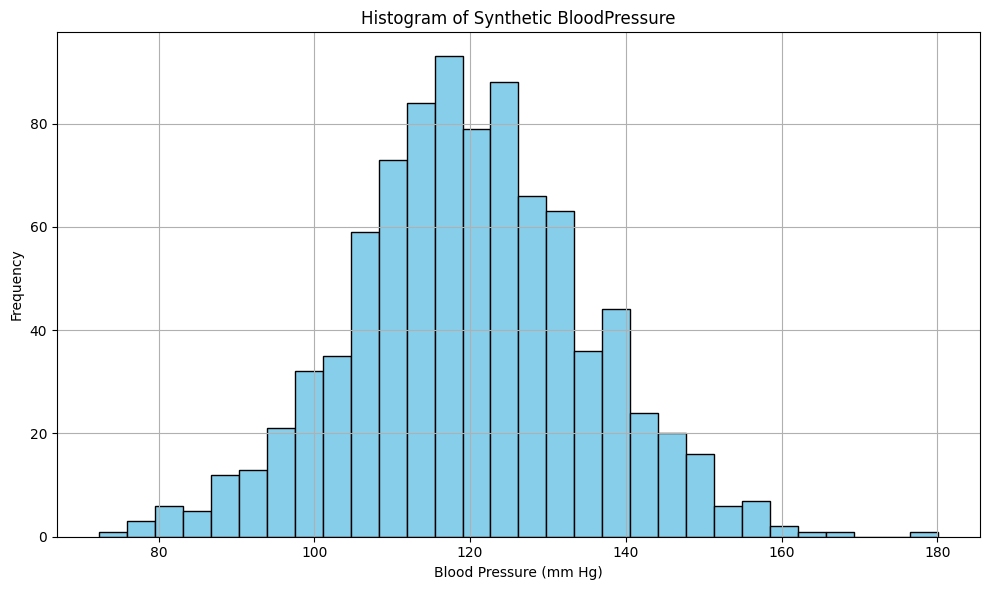

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col
import matplotlib.pyplot as plt

# Start Spark session
spark = SparkSession.builder.appName("BloodPressureHistogram").getOrCreate()

# Load dataset
df = spark.read.csv("/content/customer_purchases/customer_purchases.csv", header=True, inferSchema=True)

# Filter rows for the 2nd DataFrame (remove PurchaseAmount < 50)
df2 = df.filter(col("PurchaseAmount") >= 50)

# Create synthetic 'BloodPressure' values in the 3rd DataFrame
df3 = df2.withColumn("BloodPressure", expr("120 + randn() * 15"))

# Convert to pandas for plotting
df3_pd = df3.select("BloodPressure").toPandas()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df3_pd["BloodPressure"], bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Synthetic BloodPressure")
plt.xlabel("Blood Pressure (mm Hg)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

Q1: 6.0 Median: 10.0 Q3: 16.0


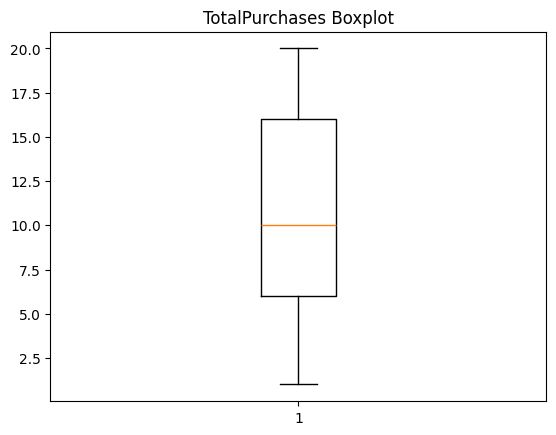

In [33]:
q = df3.approxQuantile("TotalPurchases", [0.25, 0.5, 0.75], 0.0)
print("Q1:", q[0], "Median:", q[1], "Q3:", q[2])
#Plot boxplot using matplotlib (Pandas conversion):
import matplotlib.pyplot as plt
plt.boxplot(df3.select("TotalPurchases").toPandas()["TotalPurchases"])
plt.title("TotalPurchases Boxplot")
plt.show()


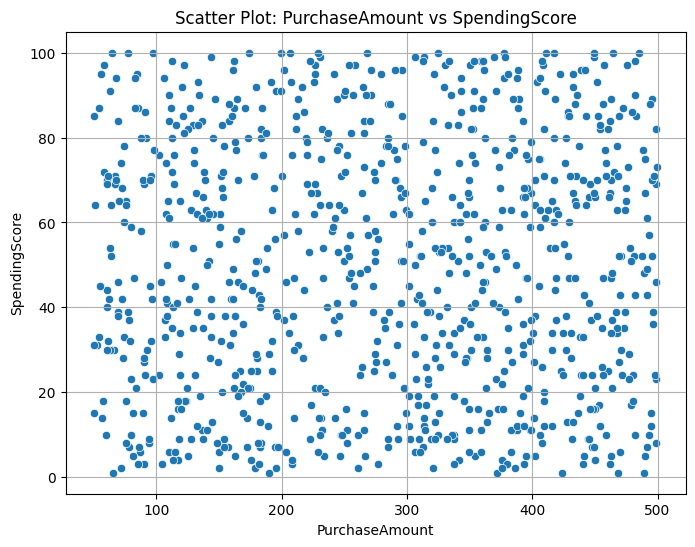

Pearson Correlation Coefficient: 0.0219


In [34]:
# Step 1: Convert PySpark DataFrame to Pandas for plotting
df_pd = df3.select("PurchaseAmount", "SpendingScore").dropna().toPandas()

# Step 2: Plot scatterplot to explore relationship
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pd, x="PurchaseAmount", y="SpendingScore")
plt.title("Scatter Plot: PurchaseAmount vs SpendingScore")
plt.xlabel("PurchaseAmount")
plt.ylabel("SpendingScore")
plt.grid(True)
plt.show()

# Step 3: Compute Pearson correlation using pandas
correlation = df_pd["PurchaseAmount"].corr(df_pd["SpendingScore"])
print(f"Pearson Correlation Coefficient: {correlation:.4f}")

In [35]:
# Step 1: Check basic stats for SpendingScore to ensure the >100 condition makes sense
df3.select("Age", "SpendingScore").describe().show()

# Optional: check max value directly
df3.selectExpr("max(SpendingScore)").show()

# Step 2: Register df3 as a temporary view
df3.createOrReplaceTempView("customer_data")

# Step 3: Run a modified query (adjust threshold if necessary)
# Change 100 to 80 if values never go over 100
result = spark.sql("""
    SELECT Age, SpendingScore
    FROM customer_data
    WHERE Age < 50 AND SpendingScore > 100
""")

# Step 4: Display the result
result.show()



+-------+------------------+------------------+
|summary|               Age|     SpendingScore|
+-------+------------------+------------------+
|  count|               891|               891|
|   mean| 42.88327721661055|49.560044893378226|
| stddev|14.650990718141372|29.464538533790392|
|    min|                18|                 1|
|    max|                70|               100|
+-------+------------------+------------------+

+------------------+
|max(SpendingScore)|
+------------------+
|               100|
+------------------+

+---+-------------+
|Age|SpendingScore|
+---+-------------+
+---+-------------+



In [36]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Add Outcome column
spending_median = df3.approxQuantile("SpendingScore", [0.5], 0.0)[0]
purchase_median = df3.approxQuantile("TotalPurchases", [0.5], 0.0)[0]
df3 = df3.withColumn("Outcome", when((col("SpendingScore") > spending_median) & (col("TotalPurchases") > purchase_median), 1).otherwise(0))

# Prepare data
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
df3 = gender_indexer.fit(df3).transform(df3)
assembler = VectorAssembler(inputCols=["Age", "AnnualIncome", "SpendingScore", "TotalPurchases", "PurchaseAmount", "GenderIndex"], outputCol="features")
data = assembler.transform(df3).select("features", "Outcome")
train, test = data.randomSplit([0.8, 0.2], seed=42)

# Train & evaluate
model = DecisionTreeClassifier(labelCol="Outcome", featuresCol="features").fit(train)
pred = model.transform(test)
accuracy = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="accuracy").evaluate(pred)
print("Decision Tree Accuracy:", accuracy)


Decision Tree Accuracy: 0.993103448275862


In [37]:
from pyspark.ml.classification import LogisticRegression
lr_model = LogisticRegression(labelCol="Outcome", featuresCol="features").fit(train)
lr_predictions = lr_model.transform(test)
lr_accuracy = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="accuracy").evaluate(lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)


Logistic Regression Accuracy: 0.9379310344827586


In [38]:
from pyspark.ml.regression import LinearRegression
assembler_lr = VectorAssembler(inputCols=["AnnualIncome"], outputCol="features")
lr_data = assembler_lr.transform(df3).select("features", "PurchaseAmount")
train_lr, test_lr = lr_data.randomSplit([0.8, 0.2], seed=42)
lr_model = LinearRegression(labelCol="PurchaseAmount", featuresCol="features").fit(train_lr)
result = lr_model.evaluate(test_lr)
print("RMSE:", result.rootMeanSquaredError)
print("R2:", result.r2)


RMSE: 130.9960027504984
R2: 0.002398513395253654
